<a href="https://colab.research.google.com/github/Nick7900/DeepLearningAudioRecognition/blob/main/Audio_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio Classifier**
We got 2-5 seconds audio sample of bird calls for this short project. We'll read these files into Python and use the TensorFlow package.

The audio files are waveforms, and we want to convert them to spectograms.

Converting the audio data into spectograms enables us to do classification using computer vision techniques such as Convolutional Neural Networks (CNN).

Once we get the spectograms, we will load them into our TensorFlow-based CNN.

The result will be a binary outcome (1 or 0). If we heard a capuchin bird, the value will be 1, else it will be 0.

The goal of this classification is to determine the density of bird cries inside a specific audio file. The final audio file with which we will compare our model will be slightly longer (3 mins each). 

These large clips must be cut into window pieces. We will then slide our TensorFlow neural network, which has been trained on 3s bird clips.

The number of calls heard can then be determined. The consecutive detection of calls will then be combined together and treated as a single event.

The output file will be a CSV containing all of the outputs.







## **Data**
The data will come from the Kaggle challenge: "Z by HP Unlocked Challenge 3 - Signal Processing".
https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

**The Task**

The Challenge is to build a Machine Learning model and code to count the number of Capuchinbird calls within a given clip. This can be done in a variety of ways and you do some research into various methods of audio recognition.

**Data Explorer**

We are going to have 3 different folders
* Forest Recordings
  - These are the full clips that we need to pass trough and count the number of calls
* Parsed_Capuchinbird_Clips
  - 3s audio clip of Capuchinbird calls
* Parsed_Not_Capuchinbird_Clips
  - 3s audio clip of not-Capuchinbird calls

## **0.Load dataset from Kaggle**
Download kaggle API to get data, see steps:

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

or

https://www.youtube.com/watch?v=ooq0LezU4FM&t=604s&ab_channel=MoTechClub

Skip this step if you have download the data locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle # Make a Kaggle folder

In [ ]:
# Copy the jason file into the kaggle folder
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/ # Copy the json-file to the Kaggle folder

##### Or do the following - Copy Kaggle file to the main directory
# !cp /content/drive/MyDrive/Kaggle_API/kaggle.json /content/
# ! cp kaggle.json ~/.kaggle/ # Copy the json-file to the Kaggle folder

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # See the different datasets in Kaggle
# ! kaggle datasets list

# Then go to the dataset and Copy API
# Website https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing?select=Parsed_Not_Capuchinbird_Clips
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

 97% 585M/604M [00:10<00:00, 51.9MB/s]
100% 604M/604M [00:10<00:00, 58.6MB/s]


In [ ]:
# Unzip the file 
!mdir data # Name of the folder
! unzip z-by-hp-unlocked-challenge-3-signal-processing.zip -d data

/bin/bash: mdir: command not found
Archive:  z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: data/Forest Recordings/recording_00.mp3  
  inflating: data/Forest Recordings/recording_01.mp3  
  inflating: data/Forest Recordings/recording_02.mp3  
  inflating: data/Forest Recordings/recording_03.mp3  
  inflating: data/Forest Recordings/recording_04.mp3  
  inflating: data/Forest Recordings/recording_05.mp3  
  inflating: data/Forest Recordings/recording_06.mp3  
  inflating: data/Forest Recordings/recording_07.mp3  
  inflating: data/Forest Recordings/recording_08.mp3  
  inflating: data/Forest Recordings/recording_09.mp3  
  inflating: data/Forest Recordings/recording_10.mp3  
  inflating: data/Forest Recordings/recording_11.mp3  
  inflating: data/Forest Recordings/recording_12.mp3  
  inflating: data/Forest Recordings/recording_13.mp3  
  inflating: data/Forest Recordings/recording_14.mp3  
  inflating: data/Forest Recordings/recording_15.mp3  
  inflating: data/Forest

## **1.Import and Install Dependencies**
### **1.1 Install Dependencies**

In [ ]:
pip install tensorflow.io

     |████████████████████████████████| 23.4 MB 5.4 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

## **2.Build Data Loading Function**
### 2.1 Define Paths to Files

In [ ]:
import random
# First we are going to test on a single file
Capuchin_dir = os.path.join('data', 'Parsed_Capuchinbird_Clips') # Directory
Not_Capuchin_dir = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips') # Directory
# Get list of files within directory
Capuchin_list = os.listdir(Capuchin_dir) 
Not_Capuchin_list = os.listdir(Not_Capuchin_dir)
# Get a random file
Capuchin_File = random.choice(Capuchin_list)
Not_Capuchin_File = random.choice(Not_Capuchin_list)

In [ ]:
from IPython.display import Audio
print(f"Displaying {Capuchin_File} which is an example of a Parsed Capuchinbird Call:")
display(Audio(os.path.join(Capuchin_dir, Capuchin_File)))

Displaying XC216012-6.wav which is an example of a Parsed Capuchinbird Call:


In [ ]:
print(f"Displaying {Not_Capuchin_File} which is an example of a Parsed Capuchinbird Call:")
display(Audio(os.path.join(Not_Capuchin_dir, Not_Capuchin_File)))

Displaying robin-chirping-3.wav which is an example of a Parsed Capuchinbird Call:


### **2.2 Build Dataloading Function**
Function is adapted from the tensorflow website:

https://stackoverflow.com/questions/58096095/how-does-tf-audio-decode-wav-get-its-contents

and

https://www.tensorflow.org/tutorials/audio/simple_audio



* Then we got the byte enoded string, which is a decoded version of the wave file (**tf.io.read_file(CAPUCHIN_FILE)**) 
* The function is expecting the file path to a specific audio-file that we want to read
* We are goingt to process the audio file and converting it to 16 kHz in a single channel (instead of stereo audio we are looking at mono audio).


In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) # Convert our sample rate into a int
    # Goes from XXX kHz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) # This will reduce the size of the final audio
    return wav

## 2.3 Plot Waves

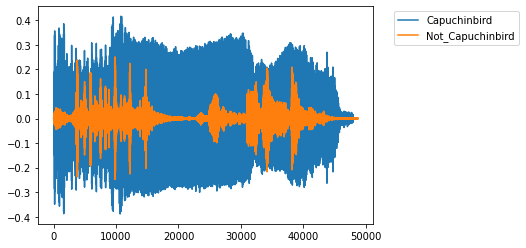

In [ ]:
# Reading the audio files
wave = load_wav_16k_mono(os.path.join(Capuchin_dir, Capuchin_File))
nwave = load_wav_16k_mono(os.path.join(Not_Capuchin_dir, Not_Capuchin_File))
# plot single figure
plt.plot(wave, label="Capuchinbird")
plt.plot(nwave, label="Not_Capuchinbird")
plt.legend(bbox_to_anchor=(1.45, 1),loc="upper right")
plt.show()

In [ ]:
# Reading the audio files
random.seed(10)
cap_list =random.sample(Capuchin_list, 3)
ncap_list =random.sample(Not_Capuchin_list, 3)

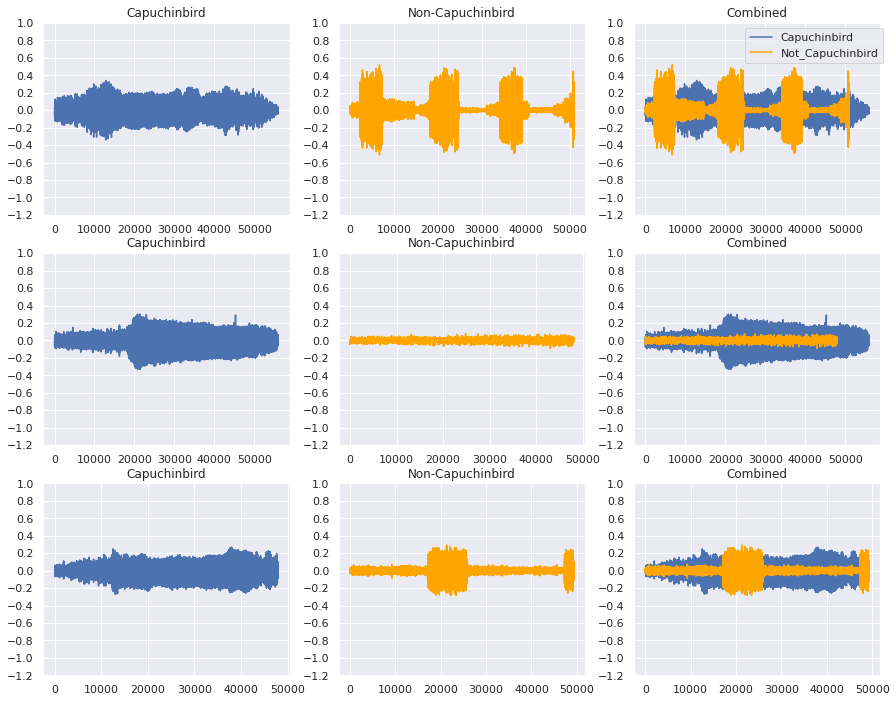

In [ ]:
import seaborn as sns
import numpy as np
sns.set()
# https://pythonguides.com/put-legend-outside-plot-matplotlib/

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

for i, name in enumerate(cap_list):
    wave = load_wav_16k_mono(os.path.join(Capuchin_dir, cap_list[i]))
    nwave = load_wav_16k_mono(os.path.join(Not_Capuchin_dir, ncap_list[i]))
    # 1 column
    axes[i,0].plot(wave)
    axes[i,0].set_yticks(np.arange(-1.2, 1.2, 0.2))
    axes[i,0].set_title('Capuchinbird')
    # 2 column
    axes[i,1].plot(nwave, color="orange")
    axes[i,1].set_yticks(np.arange(-1.2, 1.2, 0.2))
    axes[i,1].set_title('Non-Capuchinbird')
    # 3 column
    axes[i,2].plot(wave, label="Capuchinbird")
    line =axes[i,2].plot(nwave, color="orange", label="Not_Capuchinbird")
    axes[i,2].set_yticks(np.arange(-1.2, 1.2, 0.2))
    axes[i,2].set_title('Combined')
    # Only get the handle and legend of the last figure /overwriting every iteration
    handles, labels = axes[i,2].get_legend_handles_labels()
    
fig.legend(handles, labels,bbox_to_anchor=(0.69, 0.78),loc=2, borderaxespad=0.)
plt.show()


## **3. Create Tensorflow Dataset**
Now we need to convert the raw audio waveforms into a spectrogram. This will be done by using the **Short-time Fourier transform (STFT)** , which will convert our dataset into the frequency domian.  
By converting it to STFT we will get an image representation, so we can produce image classification to count the Capuchinbird density.

### **3.1 Define Paths to Positive and Negative Data**

In [ ]:
# Look at our positive and negative data
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

### **3.2 Create Tensorflow Datasets**
We use the list_files-method to get a directory list, which basically just look for files with a specific format (.wav in this case).

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
# Our tensorflow dataset path look like this
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC201990-3.wav'

### **3.3 Add labels and Combine Positive and Negative Samples**
Now we got a big list of audio files that we want to work with and their positive and negative examples.

Therefore we need to label our files, because right now it is just the files. We still dont know what is a positive example or a negative example.


In [ ]:
tf.ones(len(pos)) # defined labels for our positive values

<tf.Tensor: shape=(217,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [ ]:
len(neg)

593

It turns out that the dataset is unbalanced, so in order to increase performance later on, we need to:

- *resample or undersample our negative*

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives) # Join both datasets

In [ ]:
positives.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC178168-0.wav', 1.0)

In [ ]:
data.shuffle(10000).as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-25.wav',
 0.0)

As we can see, we now have the string path as well as the flag/label (1 or 0) of our files.

## **4. Determine Average Length of a Capuchin Call**
Now we want to determine the average length of the Capuchin Bird Call. So it is a bit of a exploratory data analysis. 

This is important because when we are going to convert our spectrogram we want to ensure that we capture what is effectively a full Capuchin Bird Call or at least the majority of it. 
Hence, when we slice the bigger audio files we will capture the entire call or the majority of it => ensure we got a good prediction. 

### **4.1 Calculate Wave Cycle Length**
1. We will loop through every file in our Capuchin Bird Call folder. 
2. Then we will use the function "load_wav_16k_mono()" to load our file into a waveform
3. We can then look at how long each file, because some might not be 3s, but might be longer or shorter. 


In [ ]:
# List of our files
os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips'))[:10]

['XC79965-0.wav',
 'XC168899-0.wav',
 'XC201990-1.wav',
 'XC456236-3.wav',
 'XC114131-2.wav',
 'XC456314-0.wav',
 'XC388470-1.wav',
 'XC387509-4.wav',
 'XC22397-5.wav',
 'XC227468-0.wav']

In [ ]:
length = []
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips', file)) # load file into waveform
  length.append(len(tensor_wave))

In [ ]:
length[:10]

[48000, 64000, 56000, 48000, 56000, 56000, 48000, 56000, 56000, 56000]

### **4.2 Calculate Mean, Min and Max**
We know that we got 16000 samples for each audio wave, but they vary in length. So we have to decide the length of our spectogram that we are going to train on.

**Note** the larger a spectogram the more variables you are going to have in the deep learning model => which means more time to train => higher latency. You want to be quick when processing the audio files in real time. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


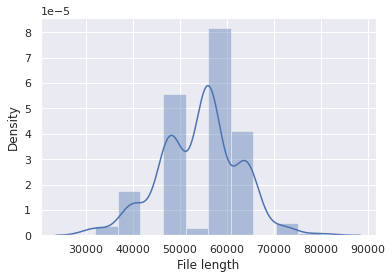

In [ ]:
# Visualize 
sns.distplot(length, bins=10, axlabel='File length',kde=True);

In [ ]:
tf.math.reduce_mean(length)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(length)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(length)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

We can see that the **mean** length is 54156 datapoins, and we got a sampling rate of 1600 Hz.

This means that the audio files got an average time length of 54156/16000 Hz = 3.38 seconds.
Aand between 2s (32000/16000) and 5s (80000/16000) in length. 

## **5. Build Preprocessing Function to Convert to Spectrogram**
Based on the histogram and measurements I have decided to have a spectrogram length of 50000 data points (equal to 3s)

In [ ]:
sample_length =48000
def preprocess(file_path, label, sample_length = 48000):
  wav = load_wav_16k_mono(file_path) # load data and convert to waveform
  wav = wav[:sample_length] # Only look at points until 48000 points
  zero_padding = tf.zeros([sample_length]- tf.shape(wav), dtype=tf.float32) # Not every file will be 48000 point long => add zeros to the array
  wav = tf.concat([zero_padding, wav], 0) # Add the number of zeros in front if padding is necessary  => Visualize tensors wav.numpy()[1990:2010]
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # Convert the signal to a spectrogram: https://www.geeksforgeeks.org/tensorflow-js-tf-signal-stft-function/
  spectrogram = tf.abs(spectrogram) # get rid of negative
  spectrogram = tf.expand_dims(spectrogram, axis=2) # expand the dimension so the data is ready for the deep leraning model => expect a channel dimension
  return spectrogram, label

# This is only used for visualizing => returning waveform
def preprocess_wav(file_path, label, sample_length = 48000):
  wav = load_wav_16k_mono(file_path) # load data and convert to waveform
  wav = wav[:sample_length] # Only look at points until 48000 points
  zero_padding = tf.zeros([sample_length]- tf.shape(wav), dtype=tf.float32) # Not every file will be 48000 point long => add zeros to the array
  wav = tf.concat([zero_padding, wav], 0) # Add the number of zeros in front if padding is necessary  => Visualize tensors wav.numpy()[1990:2010]
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # Convert the signal to a spectrogram: https://www.geeksforgeeks.org/tensorflow-js-tf-signal-stft-function/
  spectrogram = tf.abs(spectrogram) # get rid of negative
  spectrogram = tf.expand_dims(spectrogram, axis=2) # expand the dimension so the data is ready for the deep leraning model => expect a channel dimension
  return spectrogram, label, wav
 

### **5.2 Test the Function and Viz the Spectrogram**

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next() # grap a sample

In [ ]:
spectrogram, label, wav = preprocess_wav(filepath, label)

In [ ]:
np.linspace(0, 16000, num=len(a))

NameError: ignored

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(wav.numpy())
axes[0].set_title('Waveform')
start, end = axes[0].set_xlim([0, len(wav)])
a=axes[0].get_xticks().tolist()
axes[0].set_xticklabels(np.linspace(0, 16000, num=len(a)))

# Simple plot or use the plot_spectrogram function
axes[1].imshow(tf.transpose(spectrogram)[0]) # So we can see it across the time
axes[1].set_title('Spectrogram')
plt.show()

## **6. Create Training and Testing Partitions**
Rach the modelling stage.
Now it is time to make a model that cam detect single **capuchin bird calls**.
Ones the model is trained we can slice up the longer clips of the forrest into smaller windows => we can then classify if there is a **capuchin bird** in that specific clip or not. 

We can then detect the call density by aggregating the results and calculate the number of calls we have heard. 

### **6.1 Create a Tensorflow Data Pipeline**

In [ ]:
data.as_numpy_iterator().next() # data holds our string and label to our audio file

(b'data/Parsed_Capuchinbird_Clips/XC216012-3.wav', 1.0)

In [ ]:
data = data.map(preprocess) # Run our preprocessing function
data = data.cache() #store data in a temporary location instead of retrieving it from the source each time.
data = data.shuffle(len(data)) # shuffle datapoints to avoid overfit (avoid introduction unessary bias and variance into the model)
data = data.batch(16) # train on 16 samples every time
data = data.prefetch(buffer_size=tf.data.AUTOTUNE) # avoid any CPU bottleneck

## **6.2 Split into Training and Testing Partitions**
Split the dataset into training and testing samples

In [ ]:
def train_test(data,train_ratio = 0.7):
  test_ratio = 1-train_ratio
  if int(len(data)*train_ratio)+int(len(data)*train_ratio)!=len(data):
    train = data.take(int(len(data)*train_ratio+1)) # Take the first 70 % of the dataset for training 
    test = data.skip(int(len(data)*train_ratio+1)).take(int(len(data)*test_ratio)) # skip the first 70 % and take the remaining 30 % for test
  else:
    train = data.take(int(len(data)*train_ratio))
    test = data.skip(int(len(data)*train_ratio)).take(int(len(data)*test_ratio)) # skip the first 70 % and take the remaining 30 % for test
  return train, test

In [ ]:
train, test = train_test(data) # define the train and test data

### **6.3 Test One Batch**

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

In [ ]:
labels.shape # the number is 16 because of the defined batch size

(16,)

## **7. Build Deep Learning Model**
### **7.1 Load Tensorflow Dependencies**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

### **7.2 Build Sequential Model, Compile and View Summary**

In [ ]:
spectogram_size = samples.shape
spectogram_size = spectogram_size[1:]
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(spectogram_size)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss='BinaryCrossentropy', 
              metrics=[tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 743, 126, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1497888)           0         
                                                                 
 dense (Dense)               (None, 128)               191729792 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

### **7.3 Fit Model, View Loss and KPI Plots**

In [ ]:
hist = model.fit(train, 
                 epochs=10, 
                 validation_data=test)

Epoch 1/10
36/36 [==============================] - 290s 8s/step - loss: 1.5910 - recall: 0.8759 - precision: 0.7888 - val_loss: 0.0595 - val_recall: 0.9296 - val_precision: 0.9706
Epoch 2/10
36/36 [==============================] - 283s 8s/step - loss: 0.0410 - recall: 0.9542 - precision: 0.9865 - val_loss: 0.0085 - val_recall: 0.9868 - val_precision: 1.0000
Epoch 3/10
36/36 [==============================] - 281s 8s/step - loss: 0.0083 - recall: 0.9799 - precision: 1.0000 - val_loss: 8.3580e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/10
23/36 [==================>...........] - ETA: 1:35 - loss: 0.0022 - recall: 1.0000 - precision: 1.0000

KeyboardInterrupt: ignored

In [ ]:
# Plotting the history values
# hist.history
print(hist.history.keys())

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label='Loss')
plt.plot(hist.history['val_loss'], 'b', label='Validation_loss')
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
#print(hist.history.keys())
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label='precision')
plt.plot(hist.history['val_precision'], 'b', label='val_precision')
plt.legend(loc=4)
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r', label='recall')
plt.plot(hist.history['val_recall'], 'b', label='val_recall')
plt.legend(loc=4)
plt.xlabel("Epoch")
plt.show()

## **8. Make a Prediction on a Single Clip**
### 8.1 Get One Batch and Make a Prediction

In [ ]:
# Getting our spectrogram and label of a batch
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
X_test.shape

In [ ]:
y_test.shape # labels

In [ ]:
y_pred = model.predict(X_test)
y_pred

### **8.2 Convert Logits to Classes**

In [ ]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred]

In [ ]:
yhat = []
# Can also be written in the following way
for pred in y_pred:
  if pred> 0.5:
    yhat.append(1)
  else:
    yhat.append(0)


Compare with real labels of y

In [ ]:
# Can also be calculated in the following way very easy
percentage_error =sum(y_test-y_pred)/len(y_test)
percentage_error

What this shows us is that we got 0 errors or miss classifications

If we got many models, we can use the following procedure

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [ ]:
model_result =evaluate_preds(y_test,y_pred)

In [ ]:
import pandas as pd
model_results = pd.DataFrame({"Model_1":model_result})
model_results

### **Conclusion Model**
We can see that we got a very high precision and recall (100) => The higher this number is the better are we to find/detect capuchin bird calls.

Now we can apply the model to the whole audio clips and aggregate the number of calls => can calculate the density count

## **9. Build Forest Parsing Functions**
### **9.1 Load up MP3s**

In [ ]:
def load_mp3_16k_mono(filename):
  """ Load a mp3 file and convert it to a float tensor, 
  Resample to 16 kHz single-channel audio file
  """
  res = tfio.audio.AudioIOTensor(filename) # take mp3 file and convert into a tensor
  # Convert to tensor and combine channels
  tensor = res.to_tensor() # This is a multichannel tensor (not single like before)
  tensor = tf.math.reduce_sum(tensor,axis=1)/2 # Take the average between the two different channels => become single channel
  # Extract sample rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Resample to 16 kHz
  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)
  return wav

In [ ]:
# Read and test on a single file
mp3 = os.path.join("data", "Forest Recordings", "recording_00.mp3")

In [ ]:
wav = load_mp3_16k_mono(mp3) # load the mp3 file

In [ ]:
# Convert the big audio file into audio slices (same size as our model is trained on)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, # Input
                                                            wav, # Target
                                                            sequence_length=sample_length, # How long we want out sequence to be
                                                            sequence_stride=sample_length, # avoiding overlap sequences by setting them to the same size
                                                            batch_size=1)


In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
# We have taken one full audio clip and converted it into 60 different windows
# We will then use these windows and convert them into spectrograms and loop through them all.
len(audio_slices) 

In [ ]:
# Here we can see that each sample/audio clip got a sampling length of 48000 points
samples.shape

### **9.2 Build Function to Convert Clips into Windowed Spectrograms**

In [ ]:
def preprocess_mp3(sample, index, sample_length=48000):
    sample = sample[0]
    zero_padding = tf.zeros([sample_length] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

### **9.3 Convert Longer Clips into Windows and Make Predictions**

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, 
                                                            wav, 
                                                            sequence_length=sample_length, 
                                                            sequence_stride=sample_length, 
                                                            batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3) # Preprocess to spectrogram
audio_slices = audio_slices.batch(64) # Define a batch size

In [ ]:
# shape of the audio file
audio_slices.as_numpy_iterator().next().shape

In [ ]:
# Make predictions of the audio slices
y_pred = model.predict(audio_slices)
y_pred = [1 if prediction >0.9 else 0 for prediction in y_pred] # has to be 90 % sure

In [ ]:
tf.math.reduce_sum(y_pred) # Manually counting of that file only contained 5 calls

In [ ]:
tf.transpose(y_pred) # Predicted output

### Note - predicted output
We counted 5 calls manually, however when we examine at *y pred*, we discover that there are consecutive detections. This is most likely due to the fact that some of those calls are longer than 3 seconds. This means we must group the consecutive calls from 7 => 5.

### **9.4 Group Consecutive Detections**
We will loop through our predictions in *y_pred* and find do a summation of the counted bird calls

In [ ]:
from itertools import groupby

In [ ]:
# https://stackoverflow.com/questions/33118846/how-to-merge-repeated-elements-in-list-in-python
y_pred = [key for key, group in groupby(y_pred)]
calls = tf.math.reduce_sum(y_pred).numpy()

In [ ]:
calls

## **10. Make Predictions**
Now we need to loop through the whole recording directory

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
  FILEPATH = os.path.join('data','Forest Recordings', file)

  wav = load_mp3_16k_mono(FILEPATH) # Load files
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, 
                                                              wav, 
                                                              sequence_length=48000, 
                                                              sequence_stride=48000, 
                                                              batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3) # Convert into spectrogram
  audio_slices = audio_slices.batch(64)

  y_pred = model.predict(audio_slices)

  results[file] = y_pred

In [ ]:
results # for every recoding, we got a prediction for every window slide in that particular audio file
#print(list(results)[:10]) 


### **10.2 Convert Predictions into Classes**

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
#print(list(class_preds)[:10]) 

### **10.3 Group Consecutive Detections**

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
#postprocessed

In [ ]:
# https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
df =pd.DataFrame(postprocessed.items(), columns=['recording', 'capuchin_calls'])
df =df.sort_values(by=['recording']).reset_index(drop=True) # reset index
df.head()


### **Visualize the results**

In [ ]:
plt.figure(figsize = (15,8))
fig =sns.scatterplot(data=df, x=df.index, y="capuchin_calls") 
fig.set_xlabel("Recordings", fontsize = 20)
fig.set_ylabel("Capuchin bird calls", fontsize = 20)
fig.set_title('Density plot', fontsize = 20);


## **11. Export Results**

In [ ]:
# Export the result
df.to_csv('results.csv', encoding='utf-8', index=False)

Or do the following

In [ ]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',') # every value is seperated by a ','
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])